In [1]:
import pandas as pd


In [ ]:


ruta_archivo = r"C:\Users\cdavi\Desktop\Proyecto 3\Retail.xlsx"

df = pd.read_excel(ruta_archivo)


print(df.head())


print(df.info())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [ ]:

df.dropna(subset=['CustomerID'], inplace=True)


df = df[df['Quantity'] > 0]


df = df[df['UnitPrice'] > 0]


df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df['CustomerID'] = df['CustomerID'].astype(str)


In [ ]:
print("Total de clientes únicos:", df['CustomerID'].nunique())
print("Rango de fechas:", df['InvoiceDate'].min(), "->", df['InvoiceDate'].max())


print(df['Country'].value_counts().head(10))


Total de clientes únicos: 4338
Rango de fechas: 2010-12-01 08:26:00 -> 2011-12-09 12:50:00
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64


In [ ]:


import datetime as dt


fecha_referencia = df['InvoiceDate'].max() + pd.Timedelta(days=1)

print("Fecha de referencia para RFM:", fecha_referencia.date())


Fecha de referencia para RFM: 2011-12-10


In [ ]:

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (fecha_referencia - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                       # Frequency
    'TotalPrice': 'sum'                                           # Monetary
})


rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [ ]:
from sklearn.preprocessing import StandardScaler


rfm_for_clustering = rfm.copy()


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)


import numpy as np
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print(rfm_scaled_df.head())


             Recency  Frequency  Monetary
CustomerID                               
12346.0     2.334574  -0.425097  8.358668
12347.0    -0.905340   0.354417  0.250966
12348.0    -0.175360  -0.035340 -0.028596
12349.0    -0.735345  -0.425097 -0.033012
12350.0     2.174578  -0.425097 -0.191347


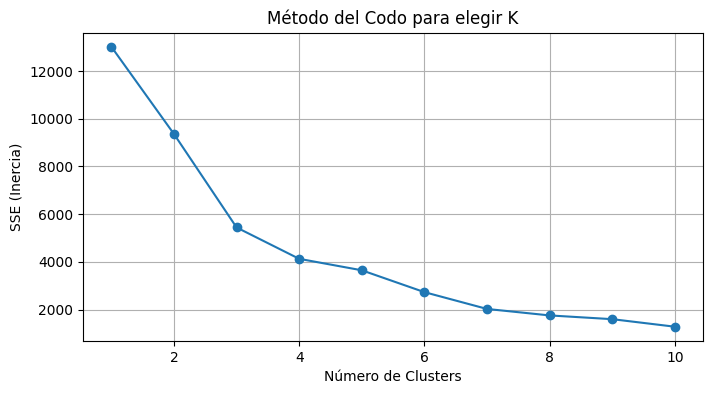

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled_df)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE (Inercia)')
plt.title('Método del Codo para elegir K')
plt.grid(True)
plt.show()


In [ ]:

kmeans = KMeans(n_clusters=4, random_state=1)
rfm_for_clustering['Cluster'] = kmeans.fit_predict(rfm_scaled_df)


print(rfm_for_clustering.groupby('Cluster').mean())



            Recency  Frequency       Monetary
Cluster                                      
0         42.412472   4.136752    1563.782438
1        247.312268   1.552974     556.665949
2         13.406250  34.739583   21702.508229
3          6.714286  65.428571  184143.690000
